# Pilot Modelling
**Preprocessing Strategy**

> Master Table
* Stratify bonding angles according to their models and troughs
* Stratify `feat_[number]` based on quantile distributions
* Stratify `pLDDT` using the split: [0,20), [20, 40),[40, 80), [80, 100)
* Split protein names (`entry`) into prefix characters, digit in the middle, and postfix characters
* Convert the strata into categorical variables
* Remove 3D coordinate
* Remove `annoatation_atomrec`

> Related Table: Amino Acid Properties
* Polarity of residue: 1 for positive, 0 for neutral, -1 for negative
* Acidicty of residue: 1 for acid, 0 for neutral, -1 for basic
* Hydrophilic/Hydrophobic: 1 for Hydrophilic, 0 for both, -1 for Hydrophobic
* Reactvity: to be decided... if it is a single number or string
* Conformational flexibity: to be decided... if it is a single number or string

* Join the related table to the master table on `annotation_sequence`
* Use amno acid prorperties in place of `annotation_sequence` during model fitting, so remove `annotation_sequence`


**Model Buidling**

> Continous Variable Selection
* Fit logistic regression curve on continuous variates like bonding angles and 3D coordinates to evaluate the variable's importance
* Stepwisely filter down to important variable to feed into the final model

> Categorical Variable Selection
* Fit logistic regression on continuous variates like amino acid properties and 3D shape of the polypeptide, watch the p-value and other statistics
* Stepwisely filter down to important variable to feed into the final model


> Pooling Continuous and Categorical Variates
* Sample 100 proteins as a pilot sample
* Fit a Decision Tree, XG Boosting on the pilot sample without tuning.
* Calculate f1_score, sensitivity, specificity, misclassification rate, deviance on a test set of 100 proteins
* Tune the decision tree by max_depth, min_sample_leaf, and cost_complexity, and different splitting criteria
* Based on best decision tree hyperparameter, train the XG Boosting model
* The XG Boosting Model by learning rate, number of trees

Pick the better performing model to train on 70% of the entire training set, use 5-fold cross validation to tune the hyperparameter. Use the best set of hyperparameter, and train on the entire training set. Make predictions on the test set, save prediction result.

>Bonus & Double Kill
* Fit a neural network on the 70% training data, 5-fold cross validation to tune paramters.
* Use the best-performing parameter set, fit the network on the entire training set.
* Stack NN, XGB, DT together to make the final predictions

References:
* [Uniprot Entry Name](https://www.uniprot.org/help/entry_name)
* [Peptide Torsion Angles and Secondary Structure](https://www.cryst.bbk.ac.uk/PPS95/course/9_quaternary/3_geometry/torsion.html#:~:text=All%20the%20amino%20acids%20have,and%20%2D50%20degrees%2C%20respectively.)
* [Phi and Psi Angles](https://proteopedia.org/wiki/index.php/Phi_and_Psi_Angles)



In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
# from xgboost import xgboost

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector, f_classif

from sklearn.metrics  import f1_score, confusion_matrix, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn import metrics

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/230219-DataHackathon/Notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/230219-DataHackathon/Notebooks


In [141]:
train_df = pd.read_csv("../Datasets/train.csv")
test_df = pd.read_csv("../Datasets/test.csv")

## Preprocessing
### Continuous Variables

In [142]:
all_protein_entries = train_df.entry.unique()
pilot_sample = all_protein_entries[0:100]
pilot_test = all_protein_entries[100:200]
pilot_sample

array(['GEMI5_HUMAN', 'ACHB4_HUMAN', 'RFC2_HUMAN', 'THIO_HUMAN',
       'ADH7_HUMAN', 'DPYL5_HUMAN', 'SRPRA_HUMAN', 'ATTY_HUMAN',
       'TN13B_HUMAN', 'ATLA1_HUMAN', 'GALE_HUMAN', 'BUB1B_HUMAN',
       'PRS6A_HUMAN', 'SMYD3_HUMAN', 'ARP2_HUMAN', 'IL1B_HUMAN',
       'MDHM_HUMAN', 'CACO2_HUMAN', 'SRP54_HUMAN', 'GRM3_HUMAN',
       'RIOK1_HUMAN', 'AOFA_HUMAN', 'ORC1_HUMAN', 'NLRP3_HUMAN',
       'ALAT2_HUMAN', 'RIOK2_HUMAN', 'ACADV_HUMAN', 'NUMA1_HUMAN',
       'GBP1_HUMAN', 'TKT_HUMAN', 'KDM1B_HUMAN', 'TNPO1_HUMAN',
       'DPOLB_HUMAN', 'CBPA2_HUMAN', 'PYC_HUMAN', 'MCLN1_HUMAN',
       'UCHL1_HUMAN', 'SCAR5_HUMAN', 'PE2R3_HUMAN', 'S14L2_HUMAN',
       'AT2A2_HUMAN', 'TAF2_HUMAN', 'DHTK1_HUMAN', 'PHF8_HUMAN',
       'HMDH_HUMAN', 'AMPE_HUMAN', 'IVD_HUMAN', 'MRP1_HUMAN',
       'R144A_HUMAN', 'METH_HUMAN', 'CPSM_HUMAN', 'ACACB_HUMAN',
       'MACD2_HUMAN', 'FFAR1_HUMAN', 'ZN224_HUMAN', 'RFC1_HUMAN',
       'M2GD_HUMAN', 'SELB_HUMAN', 'LRRT2_HUMAN', 'CMC2_HUMAN',
       'IF5_HUMAN', 'CD3

In [143]:
pilot_train = train_df.loc[train_df.entry.isin(pilot_sample)]
# pilot_train.head(),pilot_train.shape

In [144]:
pilot_test = train_df.loc[train_df.entry.isin(pilot_test)]

In [145]:
cont_var = ['feat_BBSASA', 'feat_SCSASA', 'feat_PHI', 'feat_PSI', 'feat_TAU', 'feat_THETA', 'feat_pLDDT'] + \
['feat_DSSP_'+str(i) for i in range(6,14)] + ['entry_index', 'coord_X', 'coord_Y', 'coord_Z']
cont_var

['feat_BBSASA',
 'feat_SCSASA',
 'feat_PHI',
 'feat_PSI',
 'feat_TAU',
 'feat_THETA',
 'feat_pLDDT',
 'feat_DSSP_6',
 'feat_DSSP_7',
 'feat_DSSP_8',
 'feat_DSSP_9',
 'feat_DSSP_10',
 'feat_DSSP_11',
 'feat_DSSP_12',
 'feat_DSSP_13',
 'entry_index',
 'coord_X',
 'coord_Y',
 'coord_Z']

In [146]:
# BBSASA_intervals = pd.cut(pilot_train['feat_SCSASA'], bins=30)
# ligand_by_BBSASA = pd.concat([BBSASA_intervals, pilot_train['y_Ligand']], 
#                              axis = 1).groupby("feat_SCSASA").y_Ligand.mean()
# ligand_by_BBSASA.info()
# sns.histplot(data = pilot_train, x = 'feat_SCSASA', y = pilot_train['y_Ligand'].astype(int), bins = 30)

In [147]:
# i = 0
# n = len(cont_var)
# k = n//4+1

# while i <= k:
#   fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (20,4))


#   sns.scatterplot(data = pilot_train, x = cont_var[4*i], y = 'y_Ligand', alpha = 0.1, ax = axs[0])
#   axs[0].set_title(cont_var[4*i])

#   sns.scatterplot(data = pilot_train, x = cont_var[4*i+1], y = 'y_Ligand', alpha = 0.1, ax = axs[1])
#   axs[1].set_title(cont_var[4*i+1])

#   sns.scatterplot(data = pilot_train, x = cont_var[4*i+2], y = 'y_Ligand', alpha = 0.1, ax = axs[2])
#   axs[2].set_title(cont_var[4*i+2])

#   sns.scatterplot(data = pilot_train, x = cont_var[4*i+3], y = 'y_Ligand', alpha = 0.1, ax = axs[3])
#   axs[3].set_title(cont_var[4*i+3])    
#   plt.show()

#   i += 1


signif_cont = ['feat_BBSASA', 'feat_SCSASA', 'feat_PHI', 'feat_PSI', 'feat_pLDDT', 'feat_DSSP_6', 
               'feat_DSSP_8', 'feat_DSSP_10', 'feat_DSSP_11', 'feat_DSSP_12', 'feat_DSSP_13', 'entry_index',
               'coord_X', 'coord_Y', 'coord_Z']

Observations: 
* `y_Ligands` shows a little correlation to `feat_PSI`, `feat_TAU`, `feat_DSSP_7`, `feat_DSSP_9`. 
* Ones are dense in the middle for some variables, meaning that we can stratify based on regions that are dense.

Decision:
* Stepwisely select variables to fit into logistic regression. This way, we can confirm observations above to be true.
* For variables that has a non-decreasing or non-increasing shade of ones, maintain the variable data type.

In [148]:
# X_pilot, y_pilot = pilot_train[cont_var], pilot_train.y_Ligand
# F1_scorer = make_scorer(metrics.f1_score, greater_is_better = True)
# logistic_selector = SequentialFeatureSelector(estimator = LogisticRegression(random_state=1, max_iter=5000),
#                                               n_features_to_select= 10,
#                                               # tol = 0.1,
#                                               scoring = F1_scorer)
# logistic_selector.fit(X_pilot, y_pilot)

# logistic_selector.feature_names_in_, logistic_selector.n_features_to_select_, \
# logistic_selector.support_

# cont_selector = f_classif(X_pilot, y_pilot)
# signif_dummy_ind = (cont_selector[1] < 0.05)
# signif_cont = X_pilot.columns[signif_dummy_ind]
# signif_cont




In [149]:
# col_to_drop = ['Unnamed: 0', 'annotation_atomrec'] + ['feat_PSI', 'feat_TAU', 'feat_DSSP_6', 'coord_Y']
# train_df.drop(col_to_drop, axis = 1, inplace = True)
# test_df.drop(col_to_drop, axis = 1, inplace = True)
## Temporarily drop all 3D spatial Data

## Categorical Data Preprocessing

In [150]:
## Entry name engineering
# global_unique_entry = pd.Series(train_df.entry.unique())
# pilot_entry_split = pilot_train.entry.str.extract(r'^([A-Z]+)(\d*)([A-Z]*)')

# pilot_entry_split.columns = ['prefix', 'digit', 'postfix']
# pilot_entry_split.head()

In [151]:
## Retain the digit and postfix column
## Fill '' by 'NA' string, and use it as a category
# pilot_entry_split.digit.where((pilot_entry_split.digit != '') & (pilot_entry_split.digit != np.nan),
#                               '0', inplace=True)
# pilot_entry_split.postfix.where((pilot_entry_split.postfix != '') & (pilot_entry_split.postfix != np.nan),
#                                 'NA', inplace=True)
# pilot_entry_split.info()

In [152]:
# pilot_train = pd.concat([pilot_train, pilot_entry_split], axis = 1)

# null_index = train_df.postfix.loc[train_df.postfix.isnull()].index
# pilot_EMBL = train_df.loc[null_index,'entry'].str.extract(r'(\d\w+)(\d)(\w)')
# train_df.loc[null_index,'prefix'] = pilot_EMBL.loc[:, 0]
# train_df.loc[null_index,'digit'] = pilot_EMBL.loc[:, 1]
# train_df.loc[null_index,'postfix'] = pilot_EMBL.loc[:, 2]
# train_df.loc[null_index,'prefix' : 'postfix']

# pilot_train

In [153]:
def entry_split(df):
  # Swiss naming rule
  entry_split = df.entry.str.extract(r'^([A-Z]+)(\d*)([A-Z]*)')

  entry_split.columns = ['prefix', 'digit', 'postfix']
  
  # TreEBML naming portion
  null_index = entry_split.postfix.loc[entry_split.postfix.isnull()].index
  pilot_EMBL = df.loc[null_index,'entry'].str.extract(r'(\d\w+)(\d)(\w)')

  entry_split.loc[null_index,'prefix'] = pilot_EMBL.loc[:, 0]
  entry_split.loc[null_index,'digit'] = pilot_EMBL.loc[:, 1]
  entry_split.loc[null_index,'postfix'] = pilot_EMBL.loc[:, 2]
  
  # Fill in  empty strings
  entry_split.digit.where((entry_split.digit != '') & (entry_split.digit != np.nan),
                          '0', inplace=True)
  entry_split.postfix.where((entry_split.postfix != '') & (entry_split.postfix != np.nan),
                            'NA', inplace=True)
  return pd.concat([df, entry_split], axis = 1)

In [154]:
pilot_train = entry_split(pilot_train)
pilot_test = entry_split(pilot_test)

In [155]:
top_postfix = ['NA', 'A', 'B', 'K', 'C']
top_digits = ['0', '1', '2', '3', '4']

pilot_train.digit.where(pilot_train.digit.isin(top_digits), 'Others', inplace = True)
pilot_train.postfix.where(pilot_train.postfix.isin(top_postfix), 'Others', inplace = True)

In [157]:
pilot_test.digit.where(pilot_test.digit.isin(top_digits), 'Others', inplace = True)
pilot_test.postfix.where(pilot_test.postfix.isin(top_postfix), 'Others', inplace = True)

In [ ]:
pilot_test

Augment amino acid information

In [158]:
pilot_test.digit.where(pilot_train.digit.isin(top_digits), 'Others', inplace = True)
pilot_test.postfix.where(pilot_train.postfix.isin(top_postfix), 'Others', inplace = True)

In [159]:
amino_properties = pd.read_csv("../Datasets/20 Common Amino Acids Properties - Sheet1.csv")
amino_properties['abbr'] = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H',
                            'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W',
                            'Y', 'V']
amino_properties["Sidechain Polarity"] = amino_properties["Sidechain Polarity"].map({"Polar":1, "Non-polar":0})
amino_properties["Sidechain Acidicity/Basicity"] = amino_properties["Sidechain Acidicity/Basicity"].map({"Acidic":1, "Neutral":0, "Basic":-1})
amino_properties["Hydrophobic/Hydrophilic"] = amino_properties["Hydrophobic/Hydrophilic"].map({"Hydrophilic":1, "Neutral":0, "Hydrophobic":-1})
amino_properties.drop('Name', axis = 1, inplace=True)

amino_properties.columns = ["Polarity", "Acidity", "Hydro", "Abbr"]


In [ ]:
# amino_properties.rename({"Sidechain Polarity":"Polarity", "Sidechain Acidicity/Basicity":"Acidity", "Hydrophobic/Hydrophilic":"Hydro"}, 
                        # axis = 1, inplace=True)
pilot_train = pd.merge(left = pilot_train, right = amino_properties, how = 'left', left_on='annotation_sequence', right_on='Abbr',
         suffixes = ('', ''))
pilot_test = pd.merge(left = pilot_test, right = amino_properties, how = 'left', left_on='annotation_sequence', right_on='Abbr',
         suffixes = ('', ''))
pilot_train

In [161]:
amino_col = ['Polarity', 'Acidity', 'Polarity']

In [162]:
# pilot_train.drop(["entry", "prefix", "Abbr"], axis = 1, inplace =True)
# pilot_test.drop(["entry", "prefix", "Abbr"], axis = 1, inplace =True)

# pilot_train.to_csv("230223-pilot_train.csv", index = False)
# pilot_test.to_csv("230223_pilot_test.csv",  index = False)

# pilot_train.to_csv()

In [ ]:
# train_df = pd.read_csv("../Datasets/230223_train.csv")
# test_df = pd.read_csv("../Datasets/230223_test.csv")

# pilot_train = pd.read_csv("../Datasets/230223-pilot_train.csv")
# pilot_test = pd.read_csv("../Datasets/230223_pilot_test.csv")
# pilot_train.info()

In [164]:
# Converting to categorical Data
PHI_breaks = [-1, 0, 1]
PSI_breaks = [-2, 1]
TAU_breaks = [-1]
X_breaks = [-50, 50]
Y_breaks = [-25, 25]
Z_breaks = [50, 50]

pilot_train['PHI_cate'] = pd.cut(pilot_train.feat_PHI, bins = PHI_breaks)
pilot_train['PSI_cate'] = pd.cut(pilot_train.feat_PHI, bins = PSI_breaks)
pilot_train['TAU_cate'] = pd.cut(pilot_train.feat_PHI, bins = TAU_breaks)
pilot_train['X_cate'] = pd.cut(pilot_train.coord_X, bins = X_breaks)
pilot_train['Y_cate'] = pd.cut(pilot_train.coord_Y, bins = Y_breaks)
pilot_train['Z_cate'] = pd.cut(pilot_train.coord_Z, bins = Z_breaks)

pilot_test['PHI_cate'] = pd.cut(pilot_test.feat_PHI, bins = PHI_breaks)
pilot_test['PSI_cate'] = pd.cut(pilot_test.feat_PHI, bins = PSI_breaks)
pilot_test['TAU_cate'] = pd.cut(pilot_test.feat_PHI, bins = TAU_breaks)
pilot_test['X_cate'] = pd.cut(pilot_test.coord_X, bins = X_breaks)
pilot_test['Y_cate'] = pd.cut(pilot_test.coord_Y, bins = Y_breaks)
pilot_test['Z_cate'] = pd.cut(pilot_test.coord_Z, bins = Z_breaks)

In [165]:
## Feature Selection over categorical data based on F-statistics
amino_indicator = ['feat_' + abbr for abbr in amino_properties.Abbr]
shape_indicator = ['feat_DSSP_' + abbr for abbr in ['H', 'B', 'E', 'G', 'I', 'T', 'S']]

to_dummy =  ['PHI_cate', 'PSI_cate', 'TAU_cate', 'X_cate', 'Y_cate', 'Z_cate', 'digit', 'postfix']

for col in to_dummy:
  static = pd.get_dummies(pilot_train[col], prefix = col, prefix_sep = '_')
  pilot_train.drop(col, axis = 1, inplace = True)
  pilot_train = pd.concat([pilot_train, static], axis = 1)    

for col in to_dummy:
  static = pd.get_dummies(pilot_test[col], prefix = col, prefix_sep = '_')
  pilot_test.drop(col, axis = 1, inplace = True)
  pilot_test = pd.concat([pilot_test, static], axis = 1)

 

In [166]:
cate_var = [x for x in pilot_train.columns \
            if (x not in cont_var) & \
            (x not in ['Unnamed: 0', 'annotation_sequence', 'annotation_atomrec', 'entry', 'prefix', 'y_Ligand', 'Abbr'])] 

In [ ]:
cate_var

In [168]:
X_pilot, y_pilot = pilot_train[cate_var], pilot_train['y_Ligand']
cate_selector = f_classif(X_pilot, y_pilot)

signif_dummy_ind = (cate_selector[1] < 0.05)
signif_cate = X_pilot.columns[signif_dummy_ind]
signif_cate

/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [35] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Index(['feat_A', 'feat_E', 'feat_F', 'feat_G', 'feat_P', 'feat_Q', 'feat_W',
       'feat_Y', 'feat_DSSP_H', 'feat_DSSP_B', 'feat_DSSP_E', 'feat_DSSP_G',
       'feat_DSSP_I', 'feat_DSSP_T', 'feat_DSSP_S', 'Polarity', 'Acidity',
       'Hydro', 'PHI_cate_(-1, 0]', 'X_cate_(-50, 50]', 'Y_cate_(-25, 25]',
       'digit_0', 'digit_1', 'digit_Others', 'postfix_NA', 'postfix_Others'],
      dtype='object')

In [169]:
signif_category = signif_cate.to_list()
signif_cont = ['feat_BBSASA', 'feat_SCSASA', 'feat_pLDDT', 'feat_DSSP_6', \
               'feat_DSSP_8', 'feat_DSSP_10', 'feat_DSSP_11', 'feat_DSSP_12', 'feat_DSSP_13', 'entry_index']
signif_all = signif_category + signif_cont

pilot_train.feat_BBSASA.where(pilot_train.feat_BBSASA > 0, 0, inplace = True)
pilot_train.feat_SCSASA.where(pilot_train.feat_BBSASA > 0, 0, inplace = True)


pilot_test.feat_BBSASA.where(pilot_train.feat_BBSASA > 0, 0, inplace = True)
pilot_test.feat_SCSASA.where(pilot_train.feat_BBSASA > 0, 0, inplace = True)


X_pilot, y_pilot = pilot_train[signif_all], pilot_train['y_Ligand']
X_pilot_test, y_pilot_test = pilot_test[signif_all], pilot_test['y_Ligand']

## Modelling Part

### Decision Tree

In [217]:
junior_tree = DecisionTreeClassifier(max_depth = 10, min_samples_leaf=30, min_samples_split=70,
                                     random_state = 226)
junior_tree.fit(X_pilot, y_pilot)

dict(zip(junior_tree.feature_names_in_, junior_tree.feature_importances_)),

({'feat_A': 0.0,
  'feat_E': 0.0006033580727164972,
  'feat_F': 0.0005417318441213194,
  'feat_G': 0.01882036929102765,
  'feat_P': 0.0,
  'feat_Q': 0.0,
  'feat_W': 0.0,
  'feat_Y': 0.012820993637792372,
  'feat_DSSP_H': 0.006713896195046061,
  'feat_DSSP_B': 0.0,
  'feat_DSSP_E': 0.0007422960489437849,
  'feat_DSSP_G': 0.0038890403433738123,
  'feat_DSSP_I': 0.0,
  'feat_DSSP_T': 0.0031135552751214222,
  'feat_DSSP_S': 0.01641164580706314,
  'Polarity': 0.005144332460559442,
  'Acidity': 0.007461749577971148,
  'Hydro': 0.015311063710274849,
  'PHI_cate_(-1, 0]': 0.005512004722388702,
  'X_cate_(-50, 50]': 0.0,
  'Y_cate_(-25, 25]': 0.0,
  'digit_0': 0.007816535208589678,
  'digit_1': 0.0055906639105451576,
  'digit_Others': 2.8206570795303822e-05,
  'postfix_NA': 0.0,
  'postfix_Others': 0.006631735845169952,
  'feat_BBSASA': 0.0879387714125047,
  'feat_SCSASA': 0.16324786439692499,
  'feat_pLDDT': 0.21460359821121733,
  'feat_DSSP_6': 0.1094901611106574,
  'feat_DSSP_8': 0.02884195

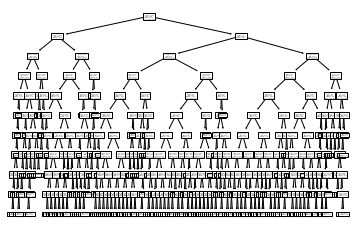

In [171]:
tree.plot_tree(junior_tree)
plt.show()

In [172]:
important_features = junior_tree.feature_names_in_[junior_tree.feature_importances_ > 0.001]
important_features

array(['feat_G', 'feat_Y', 'feat_DSSP_H', 'feat_DSSP_G', 'feat_DSSP_T',
       'feat_DSSP_S', 'Polarity', 'Acidity', 'Hydro', 'PHI_cate_(-1, 0]',
       'digit_0', 'digit_1', 'postfix_Others', 'feat_BBSASA',
       'feat_SCSASA', 'feat_pLDDT', 'feat_DSSP_6', 'feat_DSSP_8',
       'feat_DSSP_10', 'feat_DSSP_11', 'feat_DSSP_12', 'feat_DSSP_13',
       'entry_index'], dtype=object)

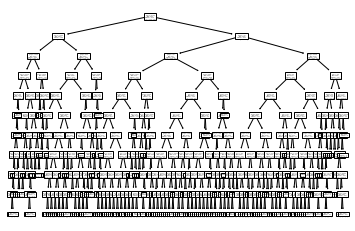

In [212]:
X_reduced, y_reduced = pilot_train[important_features], pilot_train.y_Ligand
reduced_tree = DecisionTreeClassifier(max_depth = 10, min_samples_leaf=30, min_samples_split=70,
                                     random_state = 226)
reduced_tree.fit(X_reduced, y_reduced)
dict(zip(junior_tree.feature_names_in_, junior_tree.feature_importances_)),
tree.plot_tree(reduced_tree)
plt.show()

In [234]:
def model_performance(estimator, estimator_name, X_test, y_test, perf_mtrx):
  y_prob = estimator.predict_proba(X_test)
  y_pred = estimator.predict(X_test)

  f1_loss = f1_score(y_test, y_pred, average='micro')
  accuracy = metrics.accuracy_score(y_test, y_pred) 

  conf_mtrx = metrics.confusion_matrix(y_test.tolist(), y_pred.tolist(), normalize= 'true')
  true_pos_rate = conf_mtrx[1,1]
  true_neg_rate = conf_mtrx[0,0]

  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob[:, 1], pos_label = 1)
  AUC_score = metrics.auc(fpr, tpr)

  # sns.lineplot(x = fpr, y = tpr)

  if not perf_mtrx:
    performance_df = pd.DataFrame({
      "F1_Loss":[f1_loss],
      "Accuracy": [accuracy],
      "Sensitivity": [true_pos_rate],
      "Specificity": [true_neg_rate],
      "AUC": [AUC_score]
    }, index = [estimator_name])
  else:
    perf_mtrx.loc[estimator_name] = [f1_loss, accuracy, true_pos_rate, true_neg_rate, AUC_score]

  return perf_mtrx

In [232]:
performance_df = model_performance(junior_tree, "junior_tree", X_pilot_test, 
                  y_pilot_test, perf_mtrx = None)

performance_df = model_performance(reduced_tree, "reduced_tree", X_pilot_test[important_features], 
                  y_pilot_test, performance_df)

In [237]:
y_prob = reduced_tree.predict_proba(X_pilot_test[important_features])
y_pred = (y_prob[:,1] > 0.08)
metrics.confusion_matrix(y_pilot_test.tolist(), y_pred.tolist(), normalize= 'true')
# fpr, tpr, thresholds = metrics.roc_curve(y_pilot_test, y_prob[:, 1], pos_label = 1)
# AUC_score = metrics.auc(fpr, tpr)

array([[0.90193089, 0.09806911],
       [0.65375303, 0.34624697]])

In [233]:
performance_df